In [1]:
#! wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [2]:
#! unzip jena_climate_2009_2016.csv.zip

In [3]:
from util import print_curves

### Inspect Jena Weather Dataset

In [4]:
import os
import pandas as pd

data_dir = '.'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
df = pd.read_csv(fname)

In [5]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


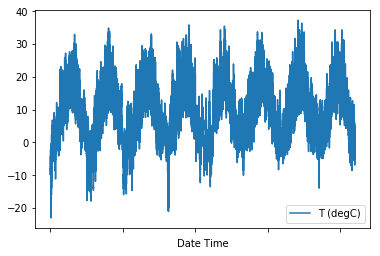

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
df.plot('Date Time','T (degC)')

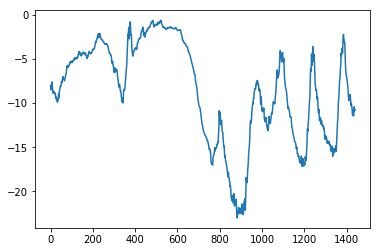

In [7]:
plt.plot(range(1440),df['T (degC)'][:1440])

### Preprocess Data

In [8]:
from sklearn import preprocessing

#df = preprocessing.scale(df.drop('Date Time', axis=1))

In [9]:
df_time = df
df = df.drop('Date Time', axis=1)

In [10]:
mean = df.mean(0)
std = df.std(0)

In [11]:
# standardize data
df = df.sub(mean, axis=1).div(std, axis=1)

In [12]:
df.std(0)

p (mbar)           1.0
T (degC)           1.0
Tpot (K)           1.0
Tdew (degC)        1.0
rh (%)             1.0
VPmax (mbar)       1.0
VPact (mbar)       1.0
VPdef (mbar)       1.0
sh (g/kg)          1.0
H2OC (mmol/mol)    1.0
rho (g/m**3)       1.0
wv (m/s)           1.0
max. wv (m/s)      1.0
wd (deg)           1.0
dtype: float64

In [13]:
df.mean(0)

p (mbar)          -3.526411e-13
T (degC)           6.469275e-15
Tpot (K)           4.183824e-13
Tdew (degC)       -1.180013e-15
rh (%)             2.505243e-14
VPmax (mbar)      -1.337905e-13
VPact (mbar)       7.613620e-15
VPdef (mbar)      -5.937364e-14
sh (g/kg)          4.250040e-14
H2OC (mmol/mol)   -4.088514e-14
rho (g/m**3)      -2.247232e-13
wv (m/s)          -2.047628e-16
max. wv (m/s)     -1.352686e-15
wd (deg)          -2.302473e-14
dtype: float64

### Create generator based on lookback, steps delay

lookback - many timesteps back the input data should go

delay - how many timesteps in the future the target should be

step - the period, in timesteps, at which you should sample data, in this case 6 for data every hour

min-index and max-index - helpful for keeping validation and testing separate

In [123]:
import numpy as np


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6,
              reverse=False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    # create offset so we don't see the same 1/step th of data in non-shuffled
    # scenario
    offset = 1

    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                # won't this reset the generator to the same place, esentially not giving us 1/6 of the data?
                # might be somewhat trivial since we're taking hourly samples,
                # so data only has changed by an hour and we're reading across
                # 8 years total dataset
                i = min_index + lookback + offset
                offset += 1
                if offset == step:
                    offset = 0
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        if reverse == True:
            yield samples[:, ::-1, :], targets
        else:
            yield samples, targets

In [124]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
num_features = df.shape[1]

Create 3 generators that look at different segments of the data

In [125]:
train_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

# how many train steps to see entire dataset
train_steps = (200000 - lookback) // batch_size

# how many val steps to see entire dataset
val_steps = (300000 - 200001 - lookback) // batch_size

# how many test steps to see entire dataset
test_steps = (len(df) - 300001 - lookback) // batch_size

# need to check if we're processing the cursor at all, i.e. are we only
# seeing 1/6 of the data since we're sampling every 6 hours
# Actually, we're shuffling, so that should take care of it, but only for
# training, in theory you want to run through 6 times, offestting,
# something like that

### Try Naive Method - Predict temp is same as 24 hours previous

In [17]:
def evaluate_naive_method():
    batch_maes = []
    # going through ALL steps was taking a long time, value is almost the same as printed
    #for step in range(val_steps):
    for step in range(500):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.abs(preds - targets)
        batch_maes.append(mae)
    return np.mean(batch_maes)

naive_mae = evaluate_naive_method()
print('naive mae: ', naive_mae)
print('Celcius Degress Error:', naive_mae * std[0])


('naive mae: ', 0.30535895521050327)
('Celcius Degress Error:', 2.5523369326611376)


So we're off by 2.54 degrees Celsius

### Try Easier MLP Method

In [95]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Flatten(input_shape=(lookback // step, num_features)))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                107552    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
1551/1551 [==============================] - 15s 9ms/step - loss: 0.0945 - mean_absolute_error: 0.2417 - val_loss: 0.2040 - val_mean_absolute_error: 0.3595
Epoch 2/3
1551/1551 [==============================] - 14s 9ms/step - loss: 0.0824 - mean_absolute_error: 0.2259 - val_loss: 0.1898 - val_mean_absolute_error: 0.3466
Epoch 3/3
1551/1551 [==============================] - 14s 9ms/step - loss: 0.0750 - mean_absolute_error: 0.2152 - val_loss: 0.1963 - val_mean_absolute_error: 0.3518


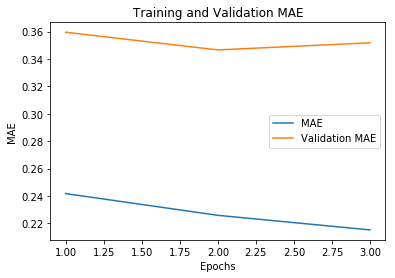

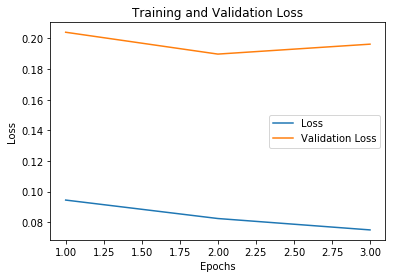

In [97]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit_generator(train_gen, epochs=20, steps_per_epoch=train_steps,
                              validation_steps=val_steps, validation_data=val_gen)

print_curves(history)

We're not really outperforming Naive. We have large hypothesis space, but it's failing to find simple solution to simple problem.

### First Recurrent Baseline

In [50]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(lookback // step, df.shape[1])))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)
print(np.min(history.history['val_mean_absolute_error']))

Epoch 1/5
481/500 [===========================>..] - ETA: 5s - loss: 0.3386 - mean_absolute_error: 0.3386

KeyboardInterrupt: 

In [ ]:
best_val_mae = np.min(history.history['val_mean_absolute_error'])
print(best_val_mae)
print(best_val_mae * std[0])

Val MAE has improved quite a bit, but we're overfitting

### Add Recurrent Dropout

Need to add double the training steps more or less because of dropout

In [54]:
model = Sequential()
model.add(GRU(32,
             dropout=0.2,
             recurrent_dropout=0.2,
             # why can we do none?
             input_shape=(None, df.shape[1])))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)

Epoch 1/20
500/500 [==============================] - 204s 407ms/step - loss: 0.3580 - mean_absolute_error: 0.3580 - val_loss: 0.2895 - val_mean_absolute_error: 0.2895
Epoch 2/20
500/500 [==============================] - 191s 382ms/step - loss: 0.3324 - mean_absolute_error: 0.3324 - val_loss: 0.2879 - val_mean_absolute_error: 0.2879
Epoch 3/20
500/500 [==============================] - 202s 404ms/step - loss: 0.3274 - mean_absolute_error: 0.3274 - val_loss: 0.2853 - val_mean_absolute_error: 0.2853
Epoch 4/20
500/500 [==============================] - 196s 391ms/step - loss: 0.3218 - mean_absolute_error: 0.3218 - val_loss: 0.2817 - val_mean_absolute_error: 0.2817
Epoch 5/20
499/500 [============================>.] - ETA: 0s - loss: 0.3178 - mean_absolute_error: 0.3178

KeyboardInterrupt: 

### Stack Recurrent Layers

In [104]:
model = Sequential()
model.add(GRU(32,
             dropout=0.1,
             recurrent_dropout=0.5,
             return_sequences = True,
             # why can we do none?
             input_shape=(None, df.shape[1])))
model.add(GRU(64, activation='relu',
             dropout=0.1,
             recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 40, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)

Epoch 1/40
371/500 [=====================>........] - ETA: 1:21 - loss: 0.3482 - mean_absolute_error: 0.3482

KeyboardInterrupt: 

We have improved a little bit, but we're bottlenecking. We're no longer overfitting, so perhaps we need a larger network for larger hypothesis space.

### Bidirectional RNNs

In [126]:
train_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    reverse=True)

val_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size,
    reverse=True)

test_gen_reverse = generator(
    df.values,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size,
    reverse=True)

In [127]:
model = Sequential()
model.add(GRU(32, input_shape=(lookback // step, df.shape[1])))
model.add(Dense(1))

model.summary()

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen_reverse, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen_reverse, validation_steps = val_steps)

print_curves(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 32)                4512      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
  8/500 [..............................] - ETA: 3:33 - loss: 0.6307 - mean_absolute_error: 0.6307

KeyboardInterrupt: 

Performs much worse, as we might be able to expect, most of the predictive power comes from the data chronologically, i.e. temperature at time t depends on t-1, whereas temp at time t does not depend on t+1

### Let's Try reverse chronological on IMDB

In [108]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Loading data...


In [114]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs = 10,
                  batch_size = 128, validation_split=0.2)

print_curves(history)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.4980 - acc: 0.7587 - val_loss: 0.3568 - val_acc: 0.8628
Epoch 2/10
 2688/20000 [===>..........................] - ETA: 1:39 - loss: 0.3337 - acc: 0.8661

KeyboardInterrupt: 

Performance is nearly identical to chronological LSTM. Order is important for language, but which order doesn't.

In [116]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 1,321,281
Trainable params: 1,321,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print_model_jupyter(model)

In [122]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs = 10,
                  batch_size = 128, validation_split=0.2)

print_curves(history)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
15104/20000 [=====================>........] - ETA: 54s - loss: 0.5915 - acc: 0.6952

KeyboardInterrupt: 

Overfits more quickly, unsurprising as we have double the number of parameters. Could regularize, then this method would likely perform more strongly than uni-directional.

### Bidirectional on Temp Data

In [130]:
model = Sequential()
model.add(layers.Bidirectional(
    GRU(32), input_shape=(lookback // step, df.shape[1])))
model.add(Dense(1))

model.summary()

model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

history = model.fit_generator(train_gen, epochs = 20, steps_per_epoch = 500,
                             validation_data = val_gen, validation_steps = val_steps)

print_curves(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 64)                9024      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 324s 648ms/step - loss: 0.3174 - mean_absolute_error: 0.3174 - val_loss: 0.2870 - val_mean_absolute_error: 0.2870
Epoch 2/20
500/500 [==============================] - 323s 647ms/step - loss: 0.2906 - mean_absolute_error: 0.2906 - val_loss: 0.2824 - val_mean_absolute_error: 0.2824
Epoch 3/20
500/500 [==============================] - 321s 643ms/step - loss: 0.2842 - mean_absolute_error: 0.2842 - val_loss: 0.2840 - val_mean_absolute_error: 0.2840
Epoch 4/20
500/500 [============

KeyboardInterrupt: 

Performs about the same as GRU layer, this is because the predictive power comes from chronological ordering of data and not reverse-chronological.